## Goal
Complexify the previous 1-hidden layer multi-layer perceptron.
* More characters in a sequence as context
* Using the architeture similar to Wavenet rather than squashing too much information quickly in one single hidden layer

## Starter code
Copy and paste from part 3: Activations, Gradients, and Batch Normalization

* Read in all the words
* Build the vocabulary of characters and mappings to/from integers
* Build the dataset

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in all the words
words = open("names.txt").read().splitlines()
len(words), words[:10]

(32033,
 ['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'])

In [3]:
# Build the vocabulary of characters and mappings to/from integers
vocab = sorted(set(''.join(words)))

stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

vocab_size = len(itos) # Used for initiate emb lookup table

print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# Build the dataset
block_size = 3 # context_length: how many characters do we take to predict the next one?
def build_dataset(words):
    xs, ys = [], []
    for word in words:
        context = [0] * block_size
        for ch in word+".":
            idx = stoi[ch]
            xs.append(context), ys.append(idx)
            context = context[1:] + [idx]
    xs, ys = torch.tensor(xs), torch.tensor(ys)
    print(xs.shape, ys.shape)
    return xs, ys

import random
random.seed(42)
random.shuffle(words)
train_idx = int(0.8 * len(words))
val_idx   = int(0.9 * len(words))

x_train, y_train = build_dataset(words[:train_idx])
x_val  , y_val   = build_dataset(words[train_idx:val_idx])
x_test , y_test  = build_dataset(words[val_idx:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
for x, y in zip(x_train[:20], y_train[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

... ---> y
..y ---> u
.yu ---> h
yuh ---> e
uhe ---> n
hen ---> g
eng ---> .
... ---> d
..d ---> i
.di ---> o
dio ---> n
ion ---> d
ond ---> r
ndr ---> e
dre ---> .
... ---> x
..x ---> a
.xa ---> v
xav ---> i
avi ---> e


In [30]:
# PyTorchified code block
# generator g is removed and set as a gobal random seed in next cell.
class Linear:
    """
    class torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    """
    def __init__(self, in_feature, out_feature, bias=True):
        # Initialize weights and bias
        self.weights = torch.randn((in_feature, out_feature)) / in_feature ** 0.5
        self.bias = torch.zeros(out_feature) if bias else None
    
    def __call__(self, x):
        # Forward pass
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        # Return a list of weighs and bias if bias is not None
        return [self.weights] + ([self.bias] if self.bias is not None else [])
    
class BatchNorm1D:
    """
    class torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)[source]
    """
    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
        # Initialize eps, momentum, training or not
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Initialize gamma and beta if affine = True. Params trained with backprop
        if affine:
            self.gamma = torch.ones(num_features)
            self.beta = torch.zeros(num_features)
        # Buffers (Trained internally with a running momentum update)
        self.mean_running = torch.zeros(num_features)
        self.var_running = torch.ones(num_features)
        
    
    def __call__(self, x):
        # If training, calculate the mean and std for x. Otherwise, use the buffer
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.mean_running
            xvar = self.var_running
        # Normalize to unit variance as xhat
        x_hat = (x - xmean) / torch.sqrt(xvar + self.eps)
        # Scale and shift to out.
        self.out = self.gamma * x_hat + self.beta
        # Update mean and std buffer if training with momentum update. without grad.
        if self.training:
            with torch.no_grad():
                self.mean_running = (1 - self.momentum) * self.mean_running + self.momentum * xmean
                self.var_running = (1 - self.momentum) * self.var_running + self.momentum * xvar
        return self.out
    
    def parameters(self):
        # Return a list of gamma, beta.
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        # Return tanh x
        self.out = torch.tanh(x)
        return self.out
        
    def parameters(self):
        # Return empty list
        return []

# PyTorchifying layers to simplify model construction
# torch.embeddings, torch.flatten
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

# Container
class Sequential:
    """
    In the forward, we call layers sequentially
    """
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # Get parameters of all layers and stretch them into a list.
        return [p for layer in self.layers for p in layer.parameters()]

In [31]:
torch.manual_seed(42); # Seed rng for reproducibility

In [32]:
n_embd = 10 # The dimensionality of the character embedding vectors
n_hidden = 200 # The number of neurons in the hidden layer of the MLP

# C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd), Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# Parameter inits
with torch.no_grad():
    layers[-1].weights *= 0.1 # Last layer make less confidently wrong

# parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

12097


In [33]:
max_steps = 200000
batch_size = 32
lossi = []

for step in range(max_steps):
    # Batch index
    idx = torch.randint(0, x_train.shape[0], (batch_size, ))
    xb, yb = x_train[idx], y_train[idx]
    
    # Forward
#     emb = C[xb]
#     x = emb.view(batch_size, -1)
#     x = xb
#     for layer in layers:
#         x = layer(x)
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)
    
    # Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if step < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # Track stats
    if step % 10000 == 0:
        print(f"{step:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.4915
  10000/ 200000: 2.2179
  20000/ 200000: 2.3681
  30000/ 200000: 2.1342
  40000/ 200000: 2.4067
  50000/ 200000: 2.2406
  60000/ 200000: 1.9608
  70000/ 200000: 1.9236
  80000/ 200000: 2.6588
  90000/ 200000: 2.0502
 100000/ 200000: 2.2596
 110000/ 200000: 1.6270
 120000/ 200000: 2.1705
 130000/ 200000: 2.2806
 140000/ 200000: 2.1980
 150000/ 200000: 1.8434
 160000/ 200000: 1.8251
 170000/ 200000: 2.3077
 180000/ 200000: 2.0817
 190000/ 200000: 2.1585


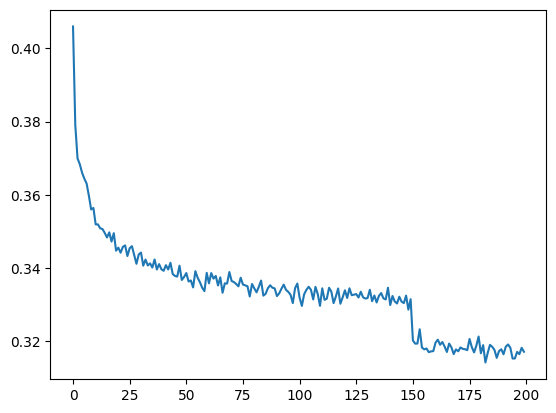

In [34]:
# Each row is now going to be 1000 consecutive loss numbers.
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1))

In [35]:
# Put layers into eval mode (needed for batchnorm to disable mean_running update)
for layer in model.layers:
    layer.training = False

In [36]:
# Evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (x_train, y_train),
        "val"  : (x_val  , y_val),
        "test" : (x_test , y_test)
    }[split]
    
#     emb = C[x]
#     x = emb.view(emb.shape[0], -1)
#     for layer in layers:
#         x = layer(x)
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss("train")
split_loss("val")

train 2.058220624923706
val 2.1056690216064453


Heads up:
* torch.tensor(context) will get a shape of [3] with 3 rows.
* torch.tensor([context]) will give the correct results with [1, 3] shape.

In [37]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # Notice that if you do torch.tensor(context) will get [0, 0, 0] which has a shape of [3] with 3 rows.
        logits = model(torch.tensor([context]))
#         emb = C[torch.tensor([context])]
#         x = emb.view(emb.shape[0], -1)
#         for layer in layers:
#             x = layer(x)
#         logits = x
        probs = F.softmax(logits, dim=1)
        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[iout] for iout in out))

ivon.
fanili.
thoommestenell.
mattevyn.
alana.
joleshaun.
siah.
prus.
carleen.
jah.
jorrena.
joriah.
jas.
vishylaharia.
juna.
vio.
orven.
mina.
laylee.
esteffead.


## PyTorchifying
* `torch.Embeddings`, `torch.Flatten` to simplify model construction.
* Container: `torch.nn`. `nn.Sequential()` and `model.parameter()`